# Spell Checker

**Simple Artificial Neural Network to classify misspelled words.**

**Libraries**

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import randint
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

**Constants**

In [14]:
# Words which whose length/number of character are within
# the range [MIN_LEN, MAX_LEN] inclusive will be used.
MIN_LEN = 3
MAX_LEN = 10

# Small alphabets will be used only, remove number or special characters.
# Space is used for padding.
ALLOWED_CHARACTERS = " " + "".join([chr(i) for i in range(97, 123)])

# Encoding string labels/correct words to numbers
label_encoder = LabelEncoder()

In [46]:
def read_dataset() -> []:
    """
        Reads the file that contains correct words, each on new line.
        Preprocess the words, which inlcudes, lower case, remove special characers,
        remove words which are not in range of [MIN_LEN, MAX_LEN],
        remove words which contains digits or special characters.
        
        Returns words list.
    """
    # Reading file and spliting lines into words
    dataset = open("words_list.txt", "r").read().split("\n")

    # Striping words with space and converting to lower case
    dataset = list(map(lambda word: word.strip().lower(), dataset))

    # Filtering the words which contains special characters
    dataset = list(filter(lambda word: word.isalpha(), dataset))

    # Filtering words which are in range of min_len and max_len
    dataset = list(filter(lambda word: MIN_LEN <= len(word) <= MAX_LEN, dataset))
    
    return dataset

def encode_string(word: str) -> []:
    """
        Parameter:
            word: string/word to be encoded into list of numbers.
        
        Returns:
            encoded_word_array: integer list of size MAX_LEN
    """
    if len(word) < MAX_LEN:
        word = word + (" " * (MAX_LEN - len(word)))
    elif len(word) > MAX_LEN:
        word = word[:MAX_LEN]
    
    encoded_word_array = [ALLOWED_CHARACTERS.index(char) for char in word]
    return encoded_word_array

def decode_string(encoded_word_array: []) -> str:
    """
        Parameter:
            encoded_word_array: array which was encoded by the function 'encoded_string'.
            
        Returns:
            word: decoded word/string from encoded_word_array.
    """
    word = "".join([ALLOWED_CHARACTERS[char] for char in encoded_word_array])
    return word.strip()

def plot_predictions(x, y, title=None):
    """
        Plots a bar chart of prediction percentage.
    """
    plt.figure(figsize=(5, 4))
    plt.bar(x, y.astype(np.float32), color="teal")
    plt.title(title)
    plt.xlabel("Words")
    plt.ylabel("Prediction %")
    plt.show()
    
def plot_history(history, labels: [], ylabel: str = None):
    plt.figure(figsize=(7, 5))
    for label in labels:
        plt.plot(history[label], label=label)
    plt.title("Training History")
    
    if ylabel:
        plt.ylabel(ylabel)
    plt.xlabel("No. epoch")
    plt.legend(loc="upper left")
    plt.show()

In [16]:
def gen_misspelled_word(word: str, neg_words_size: int, max_displacement: int = 1) -> []:
    """
        Generates misspelled word from the give words. Add random character(s) and 
        replace random character(s) to generate misspelled words. Number of character(s) that can be
        altered depends on max_displacement.
        
        Parameter:
            word: string for which misspelled words are to be generated.
            neg_words_size: number of misspelled words to be generated.
            max_displacement: integer within the [1, len(word)]. number of characters that can be altered.
            
        Returns:
            List of misspelled words.
    """
    misspelled_words = [word]
    word_len = len(word)
    add_rand_size = (neg_words_size - 1) // 2
    rep_rand_size = neg_words_size - add_rand_size - 1

    # Adding random character
    for _ in range(add_rand_size):
        rand_word = word

        rand_dis = min(MAX_LEN - len(word), randint(1, max_displacement))
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_chr = ALLOWED_CHARACTERS[randint(0, len(ALLOWED_CHARACTERS) - 1)]
            rand_word = rand_word[:rand_idx] + rand_chr + rand_word[rand_idx:]

        misspelled_words.append(rand_word)

    # Changing random character
    for _ in range(rep_rand_size):
        rand_word = word

        rand_dis = randint(1, max_displacement)
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_chr = ALLOWED_CHARACTERS[randint(0, len(ALLOWED_CHARACTERS) - 1)]
            rand_word = rand_word[:rand_idx] + rand_chr + rand_word[rand_idx + 1:]

        misspelled_words.append(rand_word)

    return misspelled_words

def generate_dataset(neg_words: int, max_displacement: int = 1):
    """
        Generates dataset from incorrect and correct words.
        
        Parameters:
            neg_words: integer. Number of misspelled words to be generated per word.
            max_displacement: integer within the [1, len(word)]. number of characters that can be altered.
            
        Returns:
            Encoded form of misspelled words and correct words.
    """
    X, y = [], []
    
    for word in tqdm(words_list, desc="Generating dataset"):
        label = label_encoder.transform([word])[0]
        X.extend([encode_string(mw) for mw in gen_misspelled_word(word, neg_words, max_displacement)])
        y.extend([label for _ in range(neg_words)])
        
    return np.array(X), np.array(y)

**Reading Dataset**

In [17]:
# Reading words from file
words_list = read_dataset()
print("Word Count:", len(words_list))

# Encoding words to number for classification
label_encoder.fit(words_list)

Word Count: 2712


LabelEncoder()

**Encoding**

In [34]:
# Generating encoded dataset from words
X, y = generate_dataset(neg_words=50, max_displacement=2)

trainX, testX, trainY, testY = train_test_split(X, y, test_size=.2)

print(f"Total size: {X.shape[0]}")
print(f"Train size: {trainX.shape[0]}")
print(f"Test size: {testX.shape[0]}")

Generating dataset: 100%|██████████| 2712/2712 [00:08<00:00, 328.65it/s]


Total size: 135600
Train size: 108480
Test size: 27120



**Classification**

In [39]:
class SpellChecker(tf.keras.models.Model):
    """
        Bidirection LSTM Classifier which predicts the correct words from misspelled words.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super(SpellChecker, self).__init__()
        
        self.embdedding_1 = layers.Embedding(input_dim=input_dim, output_dim=64)
        self.lstm_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))
        self.lstm_2 = layers.Bidirectional(layers.LSTM(64))

        
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.2)
        
        self.dense_1 = layers.Dense(20, activation="relu", kernel_initializer="he_uniform")
        self.dense_2 = layers.Dense(64, activation="relu", kernel_initializer="he_uniform")
        self.dense_3 = layers.Dense(128, activation="relu", kernel_initializer="he_uniform")
        self.dense_4 = layers.Dense(256, activation="relu", kernel_initializer="he_uniform")
        self.dense_5 = layers.Dense(512, activation="relu", kernel_initializer="he_uniform")
        self.dense_6 = layers.Dense(256, activation="relu", kernel_initializer="he_uniform")
        self.dense_7 = layers.Dense(128, activation="relu", kernel_initializer="he_uniform")
        self.dense_8 = layers.Dense(64, activation="relu", kernel_initializer="he_uniform")
        self.dense_9 = layers.Dense(output_dim, activation="softmax")
        
    def call(self, inputs):
        layer = self.embdedding_1(inputs)
        layer = self.lstm_1(layer)
        layer = self.lstm_2(layer)
        layer = self.dropout_1(layer)
        layer = self.dense_1(layer)
        layer = self.dense_2(layer)
        layer = self.dense_3(layer)
        layer = self.dense_4(layer)
        layer = self.dense_5(layer)
        layer = self.dropout_2(layer)
        layer = self.dense_6(layer)
        layer = self.dense_7(layer)
        layer = self.dense_8(layer)
        layer = self.dense_9(layer)
        
        return layer

In [41]:
model = SpellChecker(input_dim=len(ALLOWED_CHARACTERS), output_dim=len(label_encoder.classes_))
model.compile(
    optimizer=tf.optimizers.Adamax(learning_rate=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=2,
    restore_best_weights=True
)

**Training**

In [42]:
history = model.fit(
    trainX, 
    trainY, 
    epochs=100, 
    batch_size=16,
    validation_split=.2,
    callbacks=early_stopping
)

Epoch 1/100
5424/5424 [==============================] - 53s 9ms/step - loss: 7.7160 - accuracy: 6.2223e-04 - val_loss: 7.3875 - val_accuracy: 7.3746e-04
Epoch 2/100
5424/5424 [==============================] - 54s 10ms/step - loss: 7.1848 - accuracy: 0.0020 - val_loss: 6.9557 - val_accuracy: 0.0024
Epoch 3/100
5424/5424 [==============================] - 66s 12ms/step - loss: 6.6026 - accuracy: 0.0057 - val_loss: 6.4657 - val_accuracy: 0.0086
Epoch 4/100
5424/5424 [==============================] - 61s 11ms/step - loss: 6.1554 - accuracy: 0.0144 - val_loss: 6.0663 - val_accuracy: 0.0213
Epoch 5/100
5424/5424 [==============================] - 64s 12ms/step - loss: 5.8445 - accuracy: 0.0226 - val_loss: 5.8201 - val_accuracy: 0.0262
Epoch 6/100
5424/5424 [==============================] - 64s 12ms/step - loss: 5.6461 - accuracy: 0.0320 - val_loss: 5.6212 - val_accuracy: 0.0442
Epoch 7/100
5424/5424 [==============================] - 84s 15ms/step - loss: 5.4358 - accuracy: 0.0469 - val_

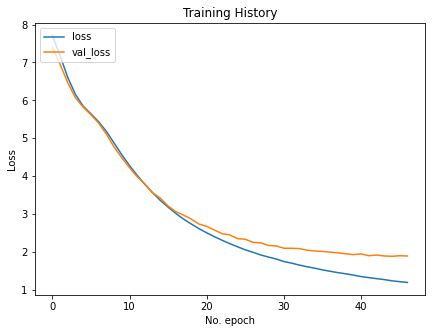

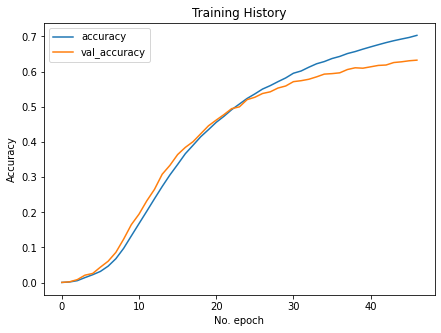

In [43]:
plot_history(history.history, ["loss", "val_loss"], ylabel="Loss")
plot_history(history.history, ["accuracy", "val_accuracy"], ylabel="Accuracy")

**Testing**

In [44]:
model.evaluate(testX, testY)

848/848 [==============================] - 5s 4ms/step - loss: 1.9241 - accuracy: 0.6208


[1.924065351486206, 0.6207964420318604]

**Prediction**

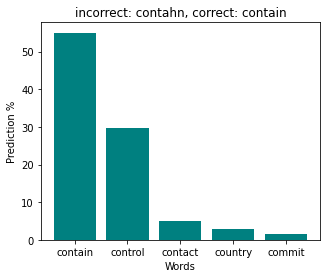

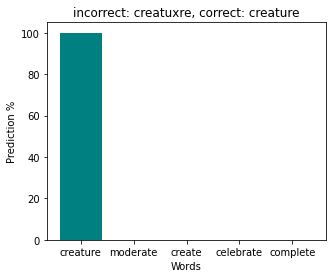

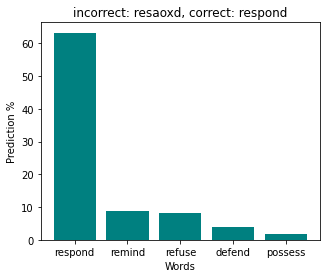

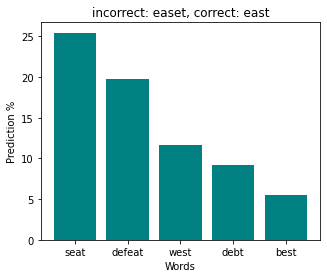

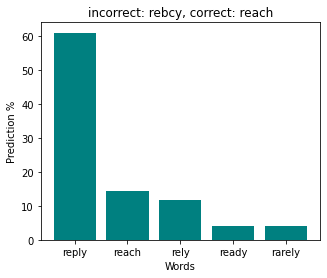

In [47]:
predX = testX[:50:10]
trueX = [decode_string(x) for x in predX]
trueY = label_encoder.inverse_transform(testY[:50:10])
predY = model.predict(predX)

for i in range(predY.shape[0]):
    pred = predY[i]
    pred = list(map(lambda x: round(x * 100, 5), pred))
    pred = list(zip(pred, label_encoder.classes_))
    pred = sorted(pred, key=lambda x: x[0], reverse=True)[:5]
    pred = np.array(pred)
    plot_predictions(pred[:, 1], pred[:, 0], title=f"incorrect: {trueX[i]}, correct: {trueY[i]}")